In [1]:
import time
import bz2
import json
import pickle
import gc

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_PATH = '/sciclone/data10/twford/reddit/reddit/comments/'
BASE_PATH = '/sciclone/geograd/stmorse/reddit/'

# Examine cluster content

In [5]:
sample_sentences, sample_embeddings = utils.sample_cluster_sentences_and_embeddings(
    0, 
    0.01,
    years=[2007],
    months=['01'],
    seed=123
)

Loading ... 
> 2007-01: cluster size 4119, sampling ... (0.13)
> Sampled (s: 41) (e: (41, 384)) (3.11)
COMPLETE: 41, (41, 384)


In [6]:
cluster_centers = utils.load_cc('mbkm_cc_20_2007_2011')
cluster_centers.shape

(20, 384)

In [7]:
closest_points = utils.get_closest_vectors(cluster_centers[0], sample_embeddings, top_k=10)
closest_sentences = [sample_sentences[i] for i in closest_points]

print('\n'.join(closest_sentences))

If the baseline was everyone in our society having good healthcare, people would have to justify being jackasses and accumulating wealth by swindling or oppressing others by other means than "I want to be able to afford cancer treatment for my kids", etc.
That's an interesting link, thanks!

From a [related post](http://angrybear.blogspot.com/2005/04/real-crisis.html):

&gt; But this is just a sample; there's virtually no metric in which the US health care system provides better care than those of other countries, other than in care for the very rich. The reality is that the average person in the US receives mediocre care that is extremely expensive.

But doesn't this beg the question of whether % of GDP is the right number to be looking at? The very rich in the US, IIRC, contribute a disproportionate amount to GDP, so shouldn't it stand to reason that they are responsible for a disproportionate share of health care costs? Bill Gates probably spends more than $5,000 a year for his heal

# Plot all clusters over a sample

In [9]:
cluster_centers = utils.load_cc('mbkm_cc_20_2007_2011')
num_clusters = cluster_centers.shape[0]
cluster_centers.shape

(20, 384)

In [10]:
sample_embeddings, sample_labels = utils.sample_embeddings_and_labels(
    0.01, 
    years=[2007],
    months=['01'],
    seed=123
)
sample_embeddings.shape

Loading ...
> 2007-01: Sampling 589 from 58954 ... (0.32)
Complete.  Labels: (589,), Embeds: (589, 384)


(589, 384)

In [11]:
tsne = TSNE(n_components=2,
            perplexity=50.0,  # similar to nearest neighbors, 5-50
            early_exaggeration=24.0)  # tight in original -> tight in embedded 
tsne_values = tsne.fit_transform(sample_embeddings)

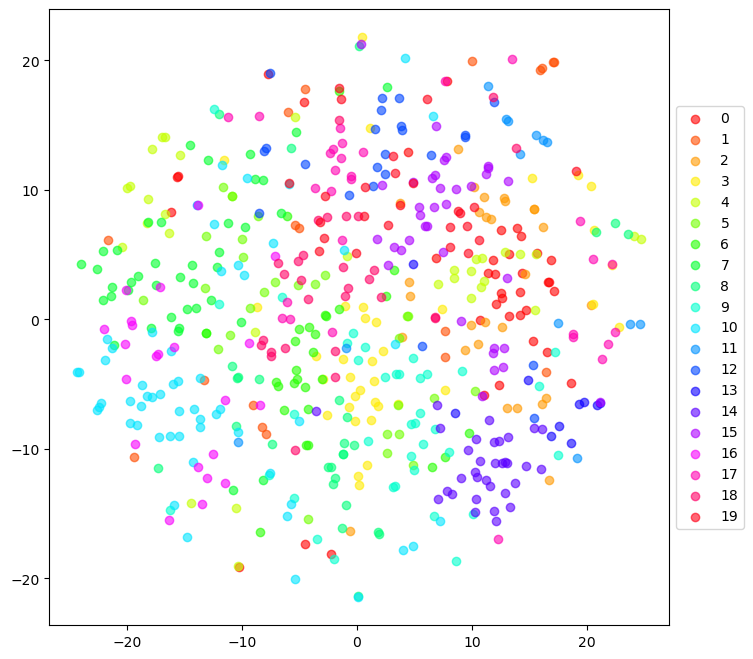

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

# get colors for each cluster
colors = plt.cm.hsv(np.linspace(0, 1, num_clusters))

for i in range(num_clusters):
    idx = np.where(sample_labels == i)[0]
    ax.scatter(tsne_values[idx, 0], 
               tsne_values[idx, 1], 
               c=[colors[i]], alpha=0.6, label=i)

# put the legend outside the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# Sub-cluster

In [ ]:
# pick a cluster
# 

# Topic dynamics

2007
- 0: Ron Paul
- 1: Bush? Texas?
- 2: Glen Beck / Finance ?
- 3: Drugs (?)
- 4: Politics (?)
- 5: Tim Osman (?)
- 6: Money / economy
- 7: ?
- 8: Rhetoric / discussion
- 9: Politics
- 10: Software

2008
- 0: Cops
- 1: "Dumbass"
- 2: ?
- 3: ?
- 4:
- 5: Reddit ?
- 11: Foreign countries 
- 16: ?
- 17: Gaming / software

2009:
- 0: Software

2010:
- 0: Exclamation marks / short words
- 1: Gaming (ish)

### Using tf-idf approach

In [4]:
# parameters for search
term = 'film'        # keyword for topic
top_k = 2                   # num clusters with this word dominant to grab
sel_clusters = []           # will hold cluster # corresponding to centroids
sel_counts = []             # will hold counts in that cluster (doc freq)
centroids = []              # will hold all centroids for these clusters
year_key = []               # keeps track of year corresponding to centroid
month = '03'                # for now just base the doc freq off one month

for year in [2007, 2008, 2009, 2010, 2011]:
    print(f'Processing {year} ...')

    # grab indices of this term in a given year
    with bz2.BZ2File(f'{DATA_PATH}RC_{year}-{month}.bz2', 'rb') as f:
        idx = []
        k = 0
        for line in f:
            entry = json.loads(line)
            if 'body' not in entry or entry['author'] == '[deleted]':
                continue
            
            if term in entry['body']:
                idx.append(k)

            k += 1

    idx = np.array(idx)
    print(idx.shape)

    # grab labels for this term
    labs = utils.load_npz(f'/sciclone/geograd/stmorse/reddit/td/', 
                          year, month, 'labels')

    # look at cluster (aka document) frequency
    cluster, count = np.unique(labs[idx], return_counts=True)
    top_c_idx = np.argsort(count)[::-1][:top_k]
    print(f'All: {[(cl, co) for cl, co in zip(cluster, count)]}')
    print(f'Top: ', cluster[top_c_idx], count[top_c_idx])
    sel_clusters.append(cluster[top_c_idx])
    sel_counts.append(count[top_c_idx])

    # grab centroids corresponding to these top clusters
    cluster_centers = utils.load_cc(f'mbkm_20_{year}_td_cc', 
                                    base_path=f'{BASE_PATH}td/')
    for i in range(top_k):
        t = cluster[top_c_idx[i]]
        centroids.append(cluster_centers[t])
        year_key.append(year)

centroids = np.vstack(centroids)
sel_counts = np.vstack(sel_counts)
sel_clusters = np.vstack(sel_clusters)
print(centroids.shape)

Processing 2007 ...
(305,)
All: [(0, 6), (1, 66), (2, 57), (3, 1), (4, 5), (5, 38), (6, 7), (7, 19), (8, 6), (9, 21), (10, 3), (11, 3), (12, 24), (13, 7), (14, 11), (15, 8), (16, 12), (17, 3), (18, 1), (19, 7)]
Top:  [1 2] [66 57]
Processing 2008 ...
(824,)
All: [(0, 31), (1, 1), (2, 110), (3, 31), (4, 87), (5, 1), (6, 2), (7, 37), (8, 9), (9, 17), (10, 9), (11, 22), (12, 59), (13, 97), (14, 17), (15, 10), (16, 19), (17, 25), (18, 209), (19, 31)]
Top:  [18  2] [209 110]
Processing 2009 ...
(2763,)
All: [(0, 99), (1, 59), (2, 255), (3, 75), (4, 155), (5, 63), (6, 30), (7, 45), (8, 57), (9, 71), (10, 23), (11, 1358), (12, 22), (13, 79), (14, 60), (15, 46), (16, 78), (17, 45), (18, 140), (19, 3)]
Top:  [11  2] [1358  255]
Processing 2010 ...
(9637,)
All: [(0, 58), (1, 331), (2, 238), (3, 184), (4, 277), (5, 91), (6, 199), (7, 140), (8, 167), (9, 292), (10, 222), (11, 38), (12, 61), (13, 215), (14, 26), (15, 123), (16, 437), (17, 277), (18, 118), (19, 6143)]
Top:  [19 16] [6143  437]
Proce

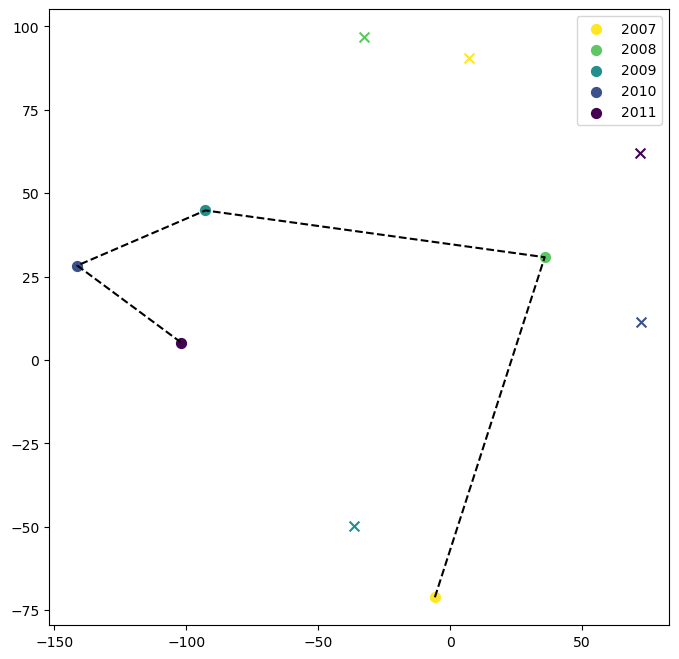

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

ld = TSNE(n_components=2, perplexity=5, early_exaggeration=12)
# ld = PCA(n_components=2)
centroids_2d = ld.fit_transform(centroids)

# plot line between main centroids
ax.plot(centroids_2d[::2, 0], centroids_2d[::2, 1], 'k--')

years = [2007, 2008, 2009, 2010, 2011]
# colors = plt.cm.hsv(np.linspace(0, 1, len(years)))
colors = plt.get_cmap('viridis_r')(np.linspace(0, 1, len(years)))

for i, color in enumerate(colors):
    k = i*2

    # main centroid
    ax.scatter(centroids_2d[k:k+1,0], centroids_2d[k:k+1,1], 
               s=50, color=color, marker='o', label=years[i])
    
    # secondary centroid
    ax.scatter(centroids_2d[k+1:k+2,0], centroids_2d[k+1:k+2,1], 
               s=50, color=color, marker='x')

ax.legend()   
plt.show()

In [15]:
sample_embeddings = [] 
sample_rates = [0.1, 0.001]

for i, (j, year) in enumerate(zip([0, 4], [2007, 2011])):
    coi = sel_clusters[j][0]
    embeddings = utils.sample_cluster_embeddings(
        coi, sample_rates[i], years=[year], months=[month],
        label_path='/sciclone/geograd/stmorse/reddit/td/')
    print(year, embeddings.shape)
    sample_embeddings.append(embeddings)

Loading ...
> 2007-03: Sampling 395 from 3951 ... (0.43)
> Sampled (e: (395, 384)) (0.86)
COMPLETE: (395, 384)
2007 (395, 384)
Loading ...
> 2011-03: Sampling 341 from 341194 ... (32.13)
> Sampled (e: (341, 384)) (64.17)
COMPLETE: (341, 384)
2011 (341, 384)


In [16]:
sample_embeddings = np.vstack(sample_embeddings)
print(sample_embeddings.shape)

# get equal amounts from each year
sample_embeddings2 = np.vstack((
    sample_embeddings[:200,:],
    sample_embeddings[395:595,:]
))
print(sample_embeddings2.shape)

(736, 384)
(400, 384)


(405, 384)


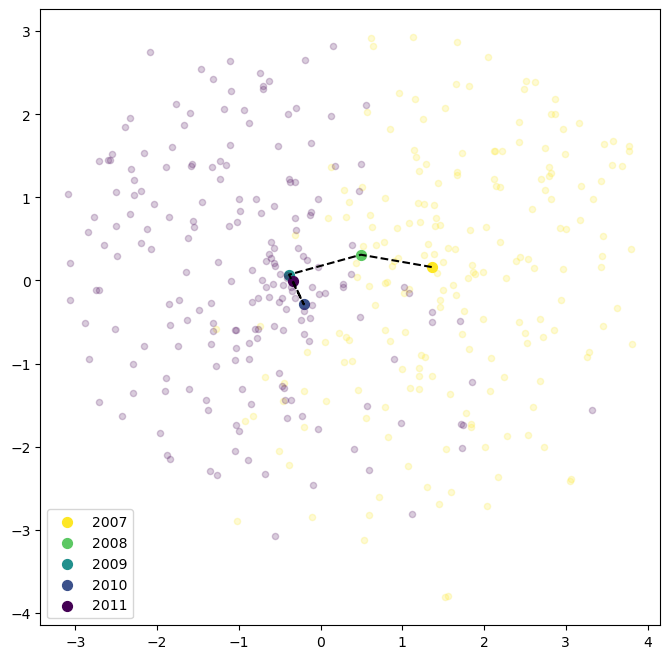

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

temp_array = np.vstack((
    sample_embeddings2,
    # centroids[[1, 3, 4, 6, 8],:]
    centroids[::2,:]
))

print(temp_array.shape)

ld = TSNE(n_components=2, perplexity=15, early_exaggeration=4)

# PCA keeps crashing the kernel, not sure why
# ld = PCA(n_components=2)

temp_2d = ld.fit_transform(temp_array)
embeds_2d = temp_2d[:400,:]
centroids_2d = temp_2d[400:]

# plot line between main centroids
ax.plot(centroids_2d[:, 0], centroids_2d[:, 1], 'k--')

years = [2007, 2008, 2009, 2010, 2011]
# # colors = plt.cm.hsv(np.linspace(0, 1, len(years)))
colors = plt.get_cmap('viridis_r')(np.linspace(0, 1, len(years)))

for i, color in enumerate(colors):

    # main centroid
    ax.scatter(centroids_2d[i,0], centroids_2d[i,1], 
               s=50, color=color, marker='o', label=years[i])
    
    if i==0:
        ax.scatter(embeds_2d[:200,0], embeds_2d[:200,1], s=20, color=color, alpha=0.2)
    elif i==4:
        ax.scatter(embeds_2d[200:,0], embeds_2d[200:,1], s=20, color=color, alpha=0.2)

ax.legend()
plt.show()

### Manual by-cluster

In [67]:
coi = 1                # cluster of interest
sample_rate = 0.01      # sample rate

sample_sentences, sample_embeddings = utils.sample_cluster_sentences_and_embeddings(
    coi, 
    sample_rate,
    years=[year],
    # months=[f'{m:02}' for m in range(1,13)],
    months=['03'],
    label_path='/sciclone/geograd/stmorse/reddit/td/',
    seed=123
)

Loading ... 
> 2010-03: cluster size 159196, sampling ... (2.71)
> Sampled (s: 1591) (e: (1591, 384)) (115.02)
COMPLETE: 1591, (1591, 384)


In [68]:
closest_points = utils.get_closest_vectors(cluster_centers[0], sample_embeddings, top_k=10)
closest_sentences = [sample_sentences[i] for i in closest_points]

print('\n'.join([s[:150] for s in closest_sentences]))

Oblivion.
Fallout Tactics.
Adeptus Mechanicus army! 

I will ease the machine's pain!
Masterba... wait no. Well, maybe. Eh try it.
[Source code](http://wonderfl.net/code/d0dcc2f2d0f8012e42785ef71dab7da2abd5453d) (and at 100% zoom so the pixels look "normal")

EDIT: HOLY CRAP. This
Big Mac.
thumbandthumber

I just wanted a new console themed name.  
Speed dial.
(With all DLC)
welcome to a battlefield game.


# User participation